In [3]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Load the CSV files
test_with_labels = pd.read_csv('/kaggle/input/testwith-labels-and-prediction/Fake_test_with_labels.csv')
predictions = pd.read_csv('/kaggle/input/testwith-labels-and-prediction/predictions_google_muril-large-cased.csv')

# Generate the Id column in test_with_labels.csv
# Assuming the first column corresponds to the Ids like Fake_01, Fake_02, etc.
test_with_labels['Id'] = ['Fake_{:02d}'.format(i + 1) for i in range(len(test_with_labels))]

# Merge the two datasets on the 'Id' column
merged = pd.merge(test_with_labels, predictions, on='Id', suffixes=('_true', '_pred'))

In [4]:
merged.head(10)

,text,label_true,Id,label_pred
0,5000 ഉള്ള പോൾ ലോഗ്‌ഡ്‌വൻ ഇപ്പോള് 250000 എന്താ...,Fake,Fake_01,Fake
1,ഓഷോ രജനീഷ് പറഞ്ഞപോലെ എനിക്കപ്പോൾ തോന്നിയത് അ...,Fake,Fake_02,Fake
2,ചേട്ടാ വാർത്ത വയ്ക്കുന്നത് കേരളത്തിലാണ് സം...,Fake,Fake_03,Fake
3,Shame for entire Woman&#39;s of Kerala,original,Fake_04,original
4,135 code janaghal andhu wide business cheythal...,Fake,Fake_05,original
5,Why not all countries club together n block ch...,Fake,Fake_06,Fake
6,Ethil appuram നാണക്കേഡ് വന്നിട്ടില്ല cpmne🤣🤣🤣a...,original,Fake_07,original
7,കൊറോണ പോയി ഒന്ന് കൂടെ മെച്ചപ്പെട്ട് ഓമൈക്രോനായ...,original,Fake_08,original
8,മോളെ. ഇത് കോമഡി സ്റ്റാർസ് അല്ല. ചിരിച്ചും കളിച...,Fake,Fake_09,original
9,Marunaadan kandupidutham,Fake,Fake_10,Fake


In [5]:


# Extract the true and predicted labels
true_labels = merged['label_true']
predicted_labels = merged['label_pred']

# Calculate the metrics
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')  # Use 'weighted' for multiclass
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Display the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Classification report for detailed metrics
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels))


Accuracy: 0.8783120706575074
F1 Score: 0.8782534392091705
Precision: 0.8788726627118059
Recall: 0.8783120706575074

Classification Report:
               precision    recall  f1-score   support

        Fake       0.89      0.86      0.88       507
    original       0.86      0.90      0.88       512

    accuracy                           0.88      1019
   macro avg       0.88      0.88      0.88      1019
weighted avg       0.88      0.88      0.88      1019



In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

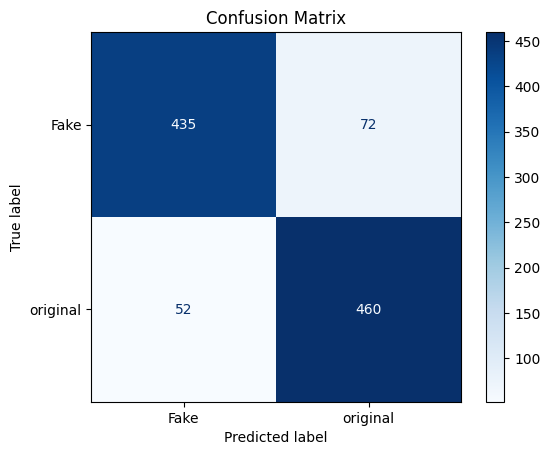

In [9]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=sorted(true_labels.unique()))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(true_labels.unique()))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [13]:
dev=pd.read_csv("/kaggle/input/fakenews/Fake_dev.csv")

In [14]:
dev.describe()

,text,label
count,815,815
unique,810,2
top,അതേയ് ങ്ങക്ക് തെറ്റീതാ ; ഇതിന്റകത് ആണുങ്ങൾ ആയി...,original
freq,2,409


In [15]:
train_df=pd.read_csv("/kaggle/input/fakenews/Fake_train.csv")


In [16]:
train_df.head()

,text,label
0,നല്ല അവതരണം. സത്യം പുറത്തു വരട്ടെ,Fake
1,Masha Allah,Fake
2,"അന്വേഷണം കഴിയുമ്പോൾ,. C. A. A. യ്ക്ക് എതിരായ ക...",Fake
3,Illathentha avaru purath vidayittalland verenth,Fake
4,Barana pakshathin matoru niyamam.nalla moyanth...,original


In [36]:
train_df["label"].value_counts()

label
original    1658
Fake        1599
Name: count, dtype: int64

In [42]:
text_column = train_df['text']

# Calculate word count for each row
train_df['word_count'] = text_column.apply(lambda x: len(str(x).split()))



In [48]:
import re

train_corpus = train_df["text"].sum()


# Remove punctuations
chars_to_ignore = '[-,\.:;\'"\!?।]'

train_corpus = re.sub(chars_to_ignore, ' ', train_corpus)
train_vocab = set(train_corpus.split())






print("Number of unique words in training data:", len(train_vocab))


Number of unique words in training data: 18526


In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

# Load the datasets
train_df = pd.read_csv('/kaggle/input/fakenews/Fake_train.csv')
test_df = pd.read_csv('/kaggle/input/fake-test-without-labels/Fake_test_without_labels.csv')

# Preprocessing
def preprocess_text(text):
    return text.strip()

train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

# Encode labels
label_mapping = {'Fake': 0, 'original': 1}
train_df['label'] = train_df['label'].map(label_mapping)

# Dataset class
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx] if self.labels is not None else -1
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'].tolist(),
    train_df['label'].tolist(),
    test_size=0.2,
    random_state=42
)

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('google/muril-large-cased')
model = AutoModelForSequenceClassification.from_pretrained('google/muril-large-cased', num_labels=2)

# Create datasets
train_dataset = FakeNewsDataset(train_texts, train_labels, tokenizer, max_length=128)
val_dataset = FakeNewsDataset(val_texts, val_labels, tokenizer, max_length=128)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

# Train the model
trainer.train()

# Evaluate the model
def compute_metrics(pred):
    predictions, labels = pred
    preds = predictions.argmax(-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='weighted')
    }

eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

# Predict on test dataset
test_dataset = FakeNewsDataset(test_df['text'].tolist(), None, tokenizer, max_length=128)
predictions = trainer.predict(test_dataset)
test_preds = predictions.predictions.argmax(-1)

# Map predictions back to labels
test_df['label'] = test_preds
test_df['label'] = test_df['label'].map({0: 'Fake', 1: 'original'})

# Save predictions to CSV
test_df[['Id', 'label']].to_csv('prediction.csv', index=False)

print("Predictions saved to prediction.csv")


In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
from gensim.models import KeyedVectors
from tqdm import tqdm

# Load the datasets
train_df = pd.read_csv('/kaggle/input/fakenews/Fake_train.csv')
test_df = pd.read_csv('/kaggle/input/fake-test-without-labels/Fake_test_without_labels.csv')

# Preprocessing
def preprocess_text(text):
    text = text.lower().strip()  # Lowercase and strip extra spaces
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])  # Remove special characters
    return text

train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

# Encode labels
label_mapping = {'Fake': 0, 'original': 1}
train_df['label'] = train_df['label'].map(label_mapping)

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'], train_df['label'], test_size=0.2, random_state=42
)

# Bag of Words for Machine Learning
vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)

# Multinomial Naive Bayes (MNB)
mnb_model = MultinomialNB()
mnb_model.fit(X_train, train_labels)
mnb_preds = mnb_model.predict(X_val)
print("Multinomial Naive Bayes:")
print(classification_report(val_labels, mnb_preds))

# Random Forest (RF)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, train_labels)
rf_preds = rf_model.predict(X_val)
print("Random Forest:")
print(classification_report(val_labels, rf_preds))





Multinomial Naive Bayes:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       342
           1       0.77      0.81      0.79       310

    accuracy                           0.80       652
   macro avg       0.80      0.80      0.80       652
weighted avg       0.80      0.80      0.80       652

Random Forest:
              precision    recall  f1-score   support

           0       0.86      0.66      0.75       342
           1       0.70      0.88      0.78       310

    accuracy                           0.77       652
   macro avg       0.78      0.77      0.77       652
weighted avg       0.79      0.77      0.76       652



**CNN+BiLSTM**

In [29]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [30]:
# Load the datasets
train_df = pd.read_csv('/kaggle/input/fakenews/Fake_train.csv')
test_df = pd.read_csv('/kaggle/input/fake-test-without-labels/Fake_test_without_labels.csv')


In [31]:
# Preprocessing
def preprocess_text(text):
    text = text.lower().strip()  # Lowercase and strip extra spaces
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])  # Remove special characters
    return text

train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

In [32]:
# Encode labels
label_mapping = {'Fake': 0, 'original': 1}
train_df['label'] = train_df['label'].map(label_mapping)

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'], train_df['label'], test_size=0.2, random_state=42
)

In [33]:
# Tokenization and Padding
def tokenize_and_index(texts, word_index, max_length):
    tokenized_texts = []
    for text in texts:
        tokens = [word_index.get(word, 0) for word in text.split()]
        tokens = tokens[:max_length] + [0] * (max_length - len(tokens))
        tokenized_texts.append(tokens)
    return np.array(tokenized_texts)

vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit(train_df['text'])
word_index = {word: i + 1 for i, word in enumerate(vectorizer.get_feature_names_out())}

max_length = 128
X_train_seq = tokenize_and_index(train_texts, word_index, max_length)
X_val_seq = tokenize_and_index(val_texts, word_index, max_length)

In [34]:
# Dataset class
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.texts[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = FakeNewsDataset(X_train_seq, train_labels.values)
val_dataset = FakeNewsDataset(X_val_seq, val_labels.values)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [35]:
# LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        lstm_out, _ = self.lstm(embedded)
        hidden_state = lstm_out[:, -1, :]  # Get the last hidden state
        return self.fc(hidden_state)

In [36]:
# Model parameters
vocab_size = len(word_index) + 1
embedding_dim = 128
hidden_dim = 128
output_dim = 2

# Instantiate model
model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [37]:
# Training and evaluation loop
def train_and_evaluate(model, train_loader, val_loader, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader):
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")

        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        print(classification_report(all_labels, all_preds))

In [38]:

# Train the model
train_and_evaluate(model, train_loader, val_loader)

100%|██████████| 163/163 [00:00<00:00, 286.35it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5, Loss: 0.6965
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       342
           1       0.48      1.00      0.64       310

    accuracy                           0.48       652
   macro avg       0.24      0.50      0.32       652
weighted avg       0.23      0.48      0.31       652



100%|██████████| 163/163 [00:00<00:00, 360.18it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/5, Loss: 0.6934
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       342
           1       0.48      1.00      0.64       310

    accuracy                           0.48       652
   macro avg       0.24      0.50      0.32       652
weighted avg       0.23      0.48      0.31       652



100%|██████████| 163/163 [00:00<00:00, 362.14it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/5, Loss: 0.6924
              precision    recall  f1-score   support

           0       0.52      1.00      0.69       342
           1       0.00      0.00      0.00       310

    accuracy                           0.52       652
   macro avg       0.26      0.50      0.34       652
weighted avg       0.28      0.52      0.36       652



100%|██████████| 163/163 [00:00<00:00, 361.41it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/5, Loss: 0.6921
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       342
           1       0.48      1.00      0.64       310

    accuracy                           0.48       652
   macro avg       0.24      0.50      0.32       652
weighted avg       0.23      0.48      0.31       652



100%|██████████| 163/163 [00:00<00:00, 360.93it/s]

Epoch 5/5, Loss: 0.6919
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       342
           1       0.48      1.00      0.64       310

    accuracy                           0.48       652
   macro avg       0.24      0.50      0.32       652
weighted avg       0.23      0.48      0.31       652




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
# Predict on test data
def predict(model, test_texts, word_index, max_length):
    test_seq = tokenize_and_index(test_texts, word_index, max_length)
    test_dataset = FakeNewsDataset(test_seq, [0] * len(test_texts))  # Dummy labels
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(test_loader):
            input_ids = batch['input_ids'].to(device)
            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(preds)

    return predictions

In [40]:

# Generate predictions and save to CSV
test_preds = predict(model, test_df['text'], word_index, max_length)
test_df['label'] = [list(label_mapping.keys())[pred] for pred in test_preds]
test_df[['Id', 'label']].to_csv('lstm_predictions.csv', index=False)
print("Predictions saved to lstm_predictions.csv")


100%|██████████| 64/64 [00:00<00:00, 866.32it/s]

Predictions saved to lstm_predictions.csv
